In [2]:
import pypangraph as pp
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from operator import truediv
import copy
from Bio import Phylo, AlignIO, SeqIO, GenBank
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import gffpandas.gffpandas as gffpd
import os
import re
import gzip
import copy

#'/home/fabrice/Documents/nlab_proj/coli_spec_case/graph/test_graph_b_20.json'
global_path = 'coli_spec_case/graph/test_graph_b_20.json'

full_graph = pp.Pangraph.load_json(global_path)
with open("archive/strains.json", 'r') as file:
    strains = json.load(file)




In [3]:
df_len = full_graph.to_blockstats_df()
df_seq = full_graph.to_blockcount_df()



In [5]:
blocks = full_graph.to_blockcount_df().columns.values.tolist()
paths = full_graph.to_blockcount_df().index.tolist()
dictionary = dict()

set_coli = set() 
set_jejuni = set()

for path in paths:
    if path.split('.')[0] in strains['coli']:
        set_coli.add(path.split('.')[0])
    elif path.split('.')[0] in strains['jejuni']:
        set_jejuni.add(path.split('.')[0])
    else:
        set_coli.add(path.split('.')[0])


for block in blocks:
    for path in paths:
        if df_seq[block][path] != 0.0:
            if block in dictionary:
                dictionary[block].append((path.split(".")[0], df_seq[block][path]))
            else:
                dictionary[block] = []
                dictionary[block].append((path.split(".")[0], df_seq[block][path]))


In [6]:

division_dict = {'core': [], 'core additional': [], 'all coli': [], 'all jejuni': [],
                'part coli': [], 'part jejuni': [], 'accesory coli': [], 'accesory jejuni': [],
                'accesory unspecific': [],'singles total': [], 'single coli': [], 
                'single jejuni': []}

division_len_dict = {'total with singlets': [0,0], 'total no singlets': [0,0], 'core': [0,0], 
                     'core additional': [0,0], 'all coli': [0,0], 'all jejuni': [0,0], 
                     'part coli': [0,0], 'part jejuni': [0,0], 'accesory coli': [0,0], 
                     'accesory jejuni': [0,0],'accesory unspecific': [0,0], 'singles total': [0,0],
                     'single coli': [0,0], 'single jejuni': [0,0]}

single_list = list()

for block in dictionary:
    tmp_set = set([path[0] for path in dictionary[block]])
    if len(tmp_set) > 1:
        if tmp_set.issubset(set_coli):
            if tmp_set == set_coli:
                division_dict['all coli'].append((block, df_len['len'][block]))
                division_len_dict['all coli'][0] += 1
                division_len_dict['all coli'][1] += df_len['len'][block]
            else:
                division_dict['part coli'].append((block, df_len['len'][block]))
                division_len_dict['part coli'][0] += 1
                division_len_dict['part coli'][1] += df_len['len'][block]
        elif tmp_set.issubset(set_jejuni):
            if tmp_set == set_jejuni:
                division_dict['all jejuni'].append((block, df_len['len'][block]))
                division_len_dict['all jejuni'][0] += 1
                division_len_dict['all jejuni'][1] += df_len['len'][block]
            else:
                division_dict['part jejuni'].append((block, df_len['len'][block]))
                division_len_dict['part jejuni'][0] += 1
                division_len_dict['part jejuni'][1] += df_len['len'][block]
        elif df_len['core'][block] and df_len['n. strains'][block] == (len(set_jejuni) + len(set_coli)):
            division_dict['core'].append((block, df_len['len'][block]))
            division_len_dict['core'][0] += 1
            division_len_dict['core'][1] += df_len['len'][block]
        else:
            if tmp_set.intersection(set_jejuni.union(set_coli)) >= set_jejuni.union(set_coli):
                division_dict['core additional'].append((block, df_len['len'][block]))
                division_len_dict['core additional'][0] += 1
                division_len_dict['core additional'][1] += df_len['len'][block]
            elif set_coli.issubset(tmp_set):
                division_dict['accesory coli'].append((block, df_len['len'][block]))
                division_len_dict['accesory coli'][0] += 1
                division_len_dict['accesory coli'][1] += df_len['len'][block]
            elif set_jejuni.issubset(tmp_set):
                division_dict['accesory jejuni'].append((block, df_len['len'][block]))
                division_len_dict['accesory jejuni'][0] += 1
                division_len_dict['accesory jejuni'][1] += df_len['len'][block]
            else:
                division_dict['accesory unspecific'].append((block, df_len['len'][block]))
                division_len_dict['accesory unspecific'][0] += 1
                division_len_dict['accesory unspecific'][1] += df_len['len'][block]
    else:
        single_list.extend(list(tmp_set))
        division_dict['singles total'].append((block, df_len['len'][block]))
        division_len_dict['singles total'][0] += 1
        division_len_dict['singles total'][1] += df_len['len'][block]
        if tmp_set.issubset(set_coli):
            division_dict['single coli'].append((block, df_len['len'][block]))
            division_len_dict['single coli'][0] += 1
            division_len_dict['single coli'][1] += df_len['len'][block]
        elif tmp_set.issubset(set_jejuni):
            division_dict['single jejuni'].append((block, df_len['len'][block]))
            division_len_dict['single jejuni'][0] += 1
            division_len_dict['single jejuni'][1] += df_len['len'][block]
            

for key in division_len_dict:
    if not key.startswith('single'):
        division_len_dict['total no singlets'][0] += division_len_dict[key][0]
        division_len_dict['total no singlets'][1] += division_len_dict[key][1]
division_len_dict['total with singlets'][0] = division_len_dict['total no singlets'][0] + \
    division_len_dict['singles total'][0]
division_len_dict['total with singlets'][1] = division_len_dict['total no singlets'][1] + \
    division_len_dict['singles total'][1]




In [7]:
x = list()
for block in dictionary:
    if set_jejuni.issubset(set(d[0] for d in dictionary[block])):
        if len(set(d[0] for d in dictionary[block]).difference(set_jejuni)) == 4:
            x.append(block)

z = list()
for b in x:
    for p in division_dict['accesory jejuni']:
        if p[0] == b:
            z.append((b, p[1]))

z

[('AAMTDKDXFU', 172),
 ('KYPUGAOGIL', 305),
 ('QGMULFCDZU', 147),
 ('CSIQYWOOKF', 238),
 ('IAARMKLRYF', 207),
 ('HDELEJYQIF', 155),
 ('KQSUFAKPUY', 159),
 ('FJJPIMEGPT', 209),
 ('IFKXKWNUCO', 242),
 ('VDCVHVKFJI', 2287),
 ('XCMCGNYDIP', 122),
 ('EGXJCFQCPG', 324),
 ('SKXLLYRPQL', 190),
 ('CKWWISHFHK', 239),
 ('NKAUARZCKO', 224),
 ('MECTGOCDRL', 858),
 ('APCQWNMIDO', 927)]

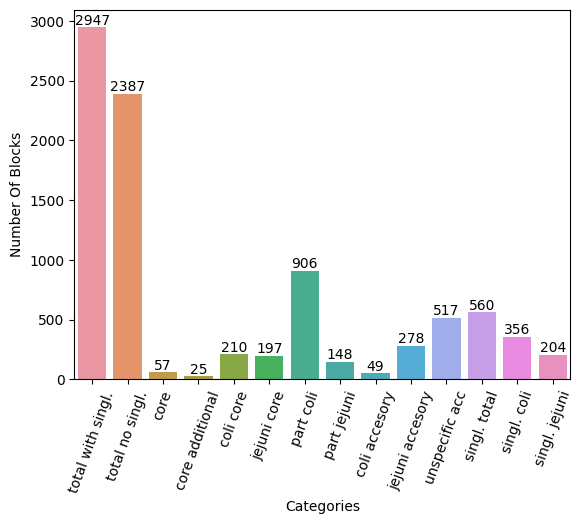

In [8]:


val = [division_len_dict['total with singlets'][0], division_len_dict['total no singlets'][0], 
       division_len_dict['core'][0], division_len_dict['core additional'][0], 
       division_len_dict['all coli'][0], division_len_dict['all jejuni'][0], 
       division_len_dict['part coli'][0], division_len_dict['part jejuni'][0], 
       division_len_dict['accesory coli'][0], division_len_dict['accesory jejuni'][0], 
       division_len_dict['accesory unspecific'][0], division_len_dict['singles total'][0],
       division_len_dict['single coli'][0], division_len_dict['single jejuni'][0]]
name = ['total with singl.', 'total no singl.', 'core', 'core additional', 'coli core', 'jejuni core',
         'part coli', 'part jejuni', 'coli accesory', 'jejuni accesory', 'unspecific acc', 
         'singl. total', 'singl. coli',  'singl. jejuni']

d = {'val': val, 'name': name}
plt_df = pd.DataFrame(data=d)


p = sns.barplot(y = 'val', x = 'name', data = plt_df)
p.set(xlabel='Categories', ylabel='Number Of Blocks')
for i in p.get_xticklabels():
    i.set_rotation(70)
for i in p.containers:
    p.bar_label(i,)

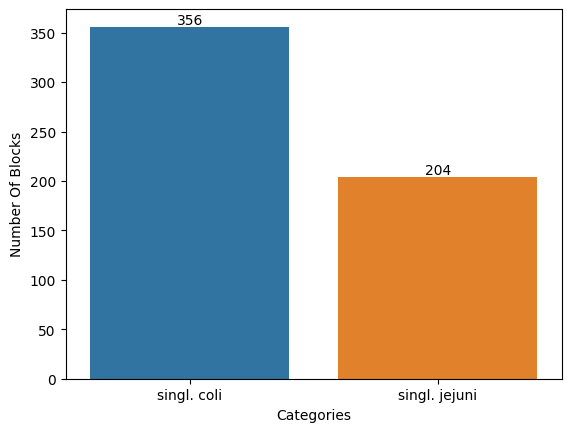

In [9]:

val = [division_len_dict['single coli'][0], division_len_dict['single jejuni'][0]]
name = ['singl. coli', 'singl. jejuni']

d = {'val': val, 'name': name}
plt_df = pd.DataFrame(data=d)


p = sns.barplot(y = 'val', x = 'name', data = plt_df)
p.set(xlabel='Categories', ylabel='Number Of Blocks')
for i in p.containers:
    p.bar_label(i,)

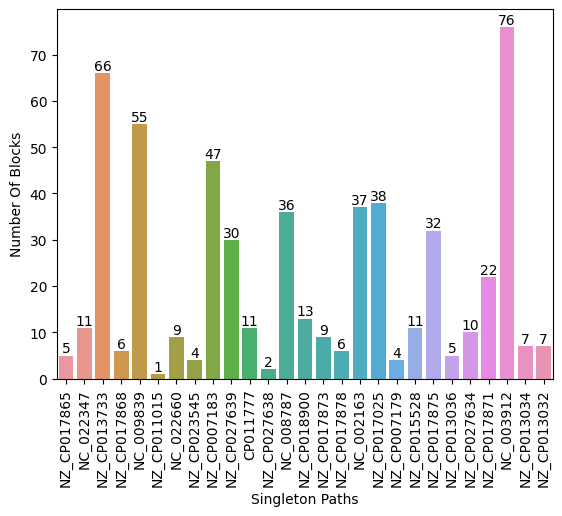

In [10]:
single_data = dict()

for path in single_list:
    if path in single_data:
        single_data[path][0] += 1
    else:
        single_data[path] = [1]

plt_df = pd.DataFrame(data=single_data)

p = sns.barplot(data = plt_df)
p.set(xlabel='Singleton Paths', ylabel='Number Of Blocks')
for i in p.get_xticklabels():
    i.set_rotation(90)
for i in p.containers:
    p.bar_label(i,)


In [11]:

blocks = df_seq.columns.values.tolist()
paths = df_seq.index.tolist()
dictionary = dict()

set_coli = set() 
set_jejuni = set()

for path in paths:
    if path.split('.')[0] in strains['coli']:
        set_coli.add(path.split('.')[0])
    elif path.split('.')[0] in strains['jejuni']:
        set_jejuni.add(path.split('.')[0])
    else:
        set_coli.add(path.split('.')[0])

for block in blocks:
    for path in paths:
        if df_seq[block][path] != 0.0:
            if block in dictionary:
                dictionary[block].append((path.split(".")[0], df_seq[block][path]))
            else:
                dictionary[block] = []
                dictionary[block].append((path.split(".")[0], df_seq[block][path]))



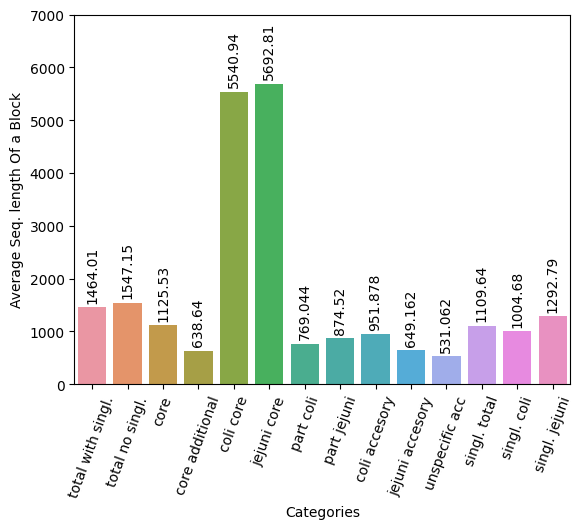

In [12]:

val_num = [division_len_dict[key][0] for key in division_len_dict]
val_len = [division_len_dict[key][1] for key in division_len_dict]


val = list(map(truediv, val_len, val_num))


name = ['total with singl.', 'total no singl.', 'core', 'core additional', 'coli core', 'jejuni core',
         'part coli', 'part jejuni', 'coli accesory', 'jejuni accesory', 'unspecific acc', 
         'singl. total', 'singl. coli',  'singl. jejuni']

d = {'val': val, 'name': name}
plt_df = pd.DataFrame(data=d)


p = sns.barplot(y = 'val', x = 'name', data = plt_df)
p.set(xlabel='Categories', ylabel='Average Seq. length Of a Block')
p.set(ylim=(0,7000))
for i in p.get_xticklabels():
    i.set_rotation(70)
for i in p.containers:
    p.bar_label(i,rotation = 90, padding = 3)

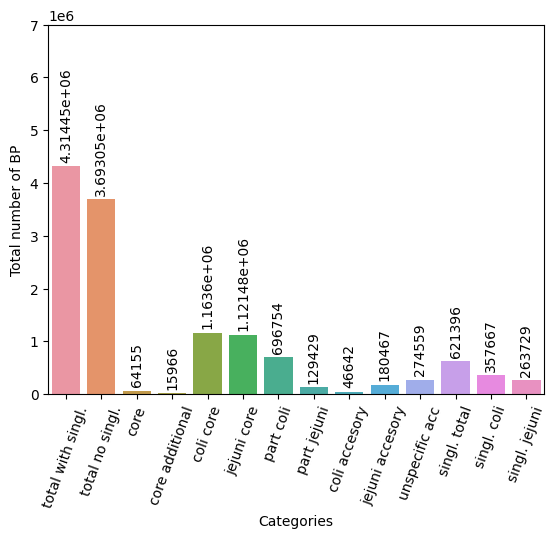

In [13]:

name = ['total with singl.', 'total no singl.', 'core', 'core additional', 'coli core', 'jejuni core',
         'part coli', 'part jejuni', 'coli accesory', 'jejuni accesory', 'unspecific acc', 
         'singl. total', 'singl. coli',  'singl. jejuni']

d = {'val': val_len, 'name': name}
plt_df = pd.DataFrame(data=d)


p = sns.barplot(y = 'val', x = 'name', data = plt_df)
p.set(xlabel='Categories', ylabel='Total number of BP')
p.set(ylim=(0,7e+06))

for i in p.get_xticklabels():
    i.set_rotation(70)
for i in p.containers:
    p.bar_label(i,rotation = 90, padding = 3)

In [14]:
with open('/home/fabrice/Documents/nlab_proj/coli_spec_case/mod_export3/vis/geneCluster.json') as file:
    table = json.load(file)

look_up = dict()
rev_look_up = dict()
file_div_dict = dict()
block_div_dict = dict()

for dic in table:
    block_div_dict[dic['ann']] = dic['divers']
    file_div_dict[dic['msa']] = dic['divers']
    look_up[dic['ann']] = dic['msa']
    rev_look_up[dic['msa']] = dic['ann']


In [15]:

def plot_tree_with_labels(original_tree, species_dic, title):
    
    plt.rc('font', size=6)

    copied_tree = copy.deepcopy(original_tree)

    counter =  0
    for clade in copied_tree.find_clades():
        if not clade.name:
            clade.name = f"U_{counter}"
            counter += 1

    label_col = {}

    for leaf in copied_tree.get_terminals():
        
        if leaf.name.split(".")[0] in species_dic["coli"]:
            c = 'green'
            leaf.color = c
            label_col.update({leaf.name : c})

        elif leaf.name.split(".")[0] in species_dic["jejuni"]:
            c = 'blue'
            leaf.color = c
            label_col.update({leaf.name : c})

        if leaf.name.split(".")[0] == "NZ_CP027638" or leaf.name.split(".")[0] == "NZ_CP027634" or leaf.name.split(".")[0] == "NZ_CP027639":
            c = 'orange'
            leaf.color = c
            label_col.update({leaf.name : c})

    fig = plt.figure(figsize=(10, 10), dpi=100)

    axes = fig.add_subplot(1, 1, 1, title = title)

    Phylo.draw(copied_tree, label_colors = label_col, axes=axes)

    plt.rc('font', size=10)

In [16]:
# for t in core[:20]:
#     a = look_up[t[0]]
#     b = Phylo.read('/home/fabrice/Documents/nlab_proj/coli_spec_case/export/vis/geneCluster/'+ a +'.nwk', 'newick')

#     plot_tree_with_labels(b, strains, f'{t[0]}_len={t[1]}')


In [17]:
annotation = dict()

files = os.listdir('/home/fabrice/Documents/nlab_proj/coli_spec_case/gff_output')

for f in files:
    annotation[f[:-5]] = gffpd.read_gff3('coli_spec_case/gff_output/' + f)


In [18]:

annotation_dict = dict()
jejuni_set = set()

for a in annotation:
    annotation_dict[a] = dict()
    gen_dict = dict()

    for n in annotation[a].df['attributes']:

        if 'gene=' in n:
            gen = re.search('gene=(.*?);', n).group(1)
            pan = re.search('pancontigs=(.*)', n).group(1)
            
            if ',' in pan:
                pan = pan.split(',')
                pan = set(map(lambda i: i[: -3], pan))
            else:
                pan = set({pan[:-3]})

            if gen in gen_dict:
                    gen_dict[gen].update(pan)
            else:
                gen_dict[gen] = set()
                gen_dict[gen].update(pan)

            if pan.intersection(set([x for x, y in division_dict['accesory jejuni']])):
                jejuni_set.update(pan)

    annotation_dict[a] = gen_dict



In [19]:
acc_list = [division_dict['accesory unspecific'], division_dict['accesory coli'], 
            division_dict['accesory jejuni']]

plot_lists = dict()

for i, a_list in enumerate(acc_list):
    count_list = [[0 for i in range(len(set_coli))] for j in range(len(set_jejuni))]
    
    for b in [block[0] for block in a_list]:
        tmp_set = set(path[0] for path in dictionary[b])
        coli_count = len(tmp_set.intersection(set_coli))
        jejuni_count = len(tmp_set.intersection(set_jejuni))
        count_list[jejuni_count - 1][coli_count - 1] += 1
        plot_lists[i] = count_list


[Text(0.5, 0, 'number of coli paths'),
 Text(0, 0.5, 'number of blocks'),
 Text(0.5, 1.0, 'Jejuni Accesory')]

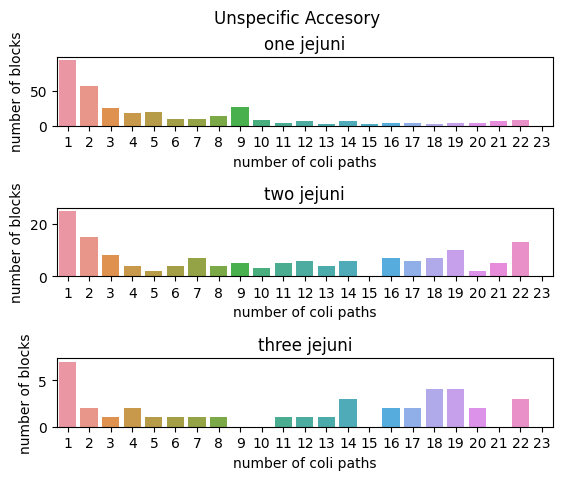

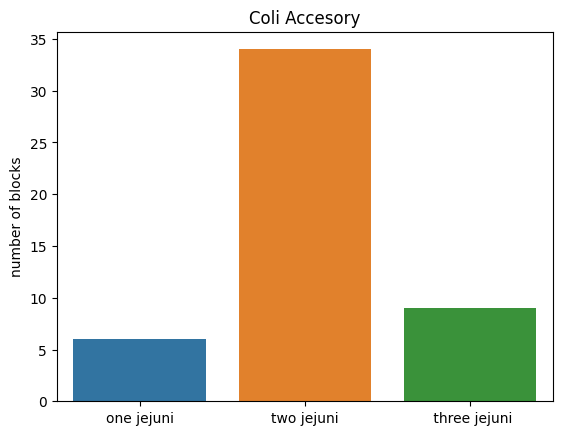

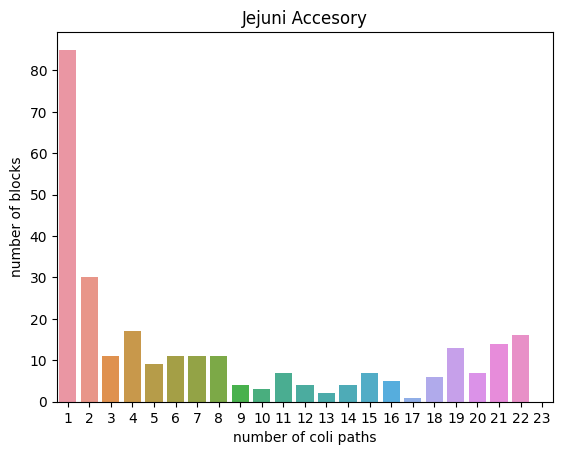

In [20]:

data = plot_lists[0]
positions = np.arange(1,len(data[0])+1)
fig, axes = plt.subplots(3, 1)
fig.suptitle('Unspecific Accesory')
plt.subplots_adjust(hspace = 1.2)
sns.barplot(ax = axes[0], x= positions, y = data[0])
axes[0].set(xlabel='number of coli paths', ylabel= 'number of blocks')
axes[0].set_title('one jejuni')
sns.barplot(ax = axes[1], x= positions, y = data[1])
axes[1].set(xlabel='number of coli paths', ylabel= 'number of blocks')
axes[1].set_title('two jejuni')
sns.barplot(ax = axes[2], x= positions, y = data[2])
axes[2].set(xlabel='number of coli paths', ylabel= 'number of blocks')
axes[2].set_title('three jejuni')


plt.figure()
data = [l[-1] for l in plot_lists[1]][:3]
name = ['one jejuni', 'two jejuni', ' three jejuni']

d = {'val': data, 'name': name}
plt_df = pd.DataFrame(data=d)
p = sns.barplot(y = 'val', x = 'name', data = plt_df)
p.set(xlabel= '', ylabel='number of blocks', title= 'Coli Accesory')


plt.figure()
data = plot_lists[2][3]
name = np.arange(1,len(data)+1)

d = {'val': data, 'name': name}
plt_df = pd.DataFrame(data=d)
p = sns.barplot(y = 'val', x = 'name', data = plt_df)
p.set(xlabel='number of coli paths', ylabel= 'number of blocks', title= 'Jejuni Accesory')

        

In [21]:

def calculate_diversity(aln):
    nuc_alpha = "acgt-n"
    aln_array = np.char.lower(np.array(aln))
    af = np.zeros((len(nuc_alpha), aln_array.shape[1]))
    for ai, state in enumerate(nuc_alpha):
        af[ai] += (aln_array == state).mean(axis=0)

    af[-1] = 1.0 - af[:-1].sum(axis=0)
    is_valid = af[:-2].sum(axis=0) > 0.5
    tmp_af = af[:-2, is_valid] / af[:-2, is_valid].sum(axis=0)
    diversity_nuc = np.mean(1.0 - (tmp_af**2).sum(axis=0))
    return round(diversity_nuc, 3)



In [22]:
diversity_list = list()
path = '/home/fabrice/Documents/nlab_proj/coli_spec_case/mod_export3/vis/geneCluster'
for file in os.listdir(path):
    if file.endswith('_na_aln.fa.gz'):
        with gzip.open(path + '/' + file, 'rt') as f_in:
            alignment = AlignIO.read(f_in, "fasta")
            div = calculate_diversity(alignment)
            diversity_list.append((file.split('_')[0], div))
            diversity_list = sorted(diversity_list, key=lambda a: a[0])

# diversity_list2 = list()
# path = '/home/fabrice/Documents/nlab_proj/coli_spec_case/export3/vis/geneCluster'
# for file in os.listdir(path):
#     if file.endswith('_na_aln.fa.gz'):
#         with gzip.open(path + '/' + file, 'rt') as f_in:
#             alignment = AlignIO.read(f_in, "fasta")
#             div = calculate_diversity(alignment)
#             diversity_list2.append((file.split('_')[0], div))
#             diversity_list2 = sorted(diversity_list, key=lambda a: a[0])

In [23]:
# diversity_list3 = list()
# path = '/home/fabrice/Documents/nlab_proj/coli_spec_case/export/aln/mafft'
# for i, file in enumerate(sorted(os.listdir(path))):
#     with open(path + '/' + file, 'rt') as f_in:
#         if not os.stat(path + '/' + file).st_size == 0:
#             alignment = AlignIO.read(f_in, "fasta")
#             div = calculate_diversity(alignment)
#             diversity_list3.append((file.split('_')[0], div))
#             diversity_list3 = sorted(diversity_list, key=lambda a: a[0])

<Axes: xlabel='diversity', ylabel='Proportion'>

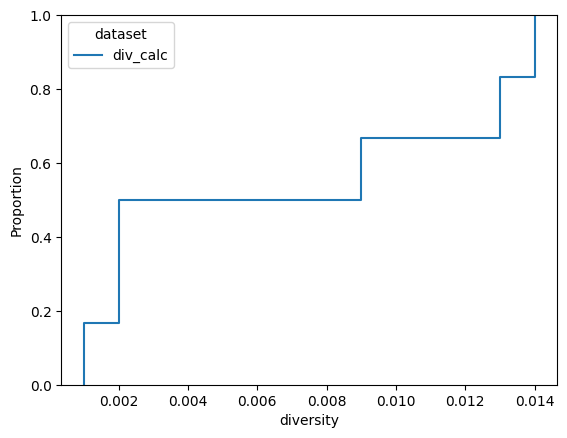

In [24]:
#df1 = [('div_file', file_div_dict[key]) for key in file_div_dict]
df2 = [('div_calc', tup[1]) for tup in diversity_list]
# df3 = [('div_calc3', tup[1]) for tup in diversity_list3]

#df1 = pd.DataFrame(df1)
df2 = pd.DataFrame(df2)
# df3 = pd.DataFrame(df3)
div_concat = pd.concat([df2]).sort_index(kind='merge')
div_concat.columns = ['dataset', 'diversity']


sns.ecdfplot(data = div_concat, x='diversity', hue='dataset')



<Axes: xlabel='diversity file', ylabel='diversity calc'>

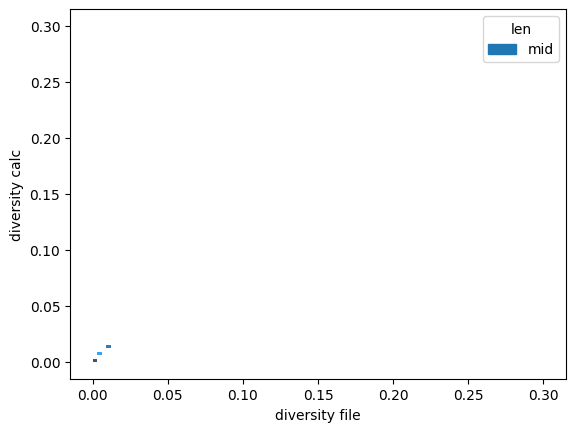

In [25]:
fd = {'diversity file': [], 'diversity calc': [], 'len': []}

for i, key in enumerate(file_div_dict):
      if df_len.loc[rev_look_up[key]]['count'] > 1:
            if df_len.loc[rev_look_up[key]]['len'] <= 100:
                  fd['diversity file'].append(file_div_dict[key])
                  fd['len'].append('short')
            elif df_len.loc[rev_look_up[key]]['len'] <= 1000:
                  fd['diversity file'].append(file_div_dict[key])
                  fd['len'].append('mid')
            else:
                  fd['diversity file'].append(file_div_dict[key])
                  fd['len'].append('long')

for f in sorted(diversity_list, key= lambda a: a[0]):
      if df_len.loc[rev_look_up[f[0]]]['count'] > 1:
            fd['diversity calc'].append(f[1])

b =np.linspace(0, 0.3, 100)

fd = pd.DataFrame(fd, columns=['diversity file','diversity calc', 'len'])
sns.histplot(data= fd, x= 'diversity file', y='diversity calc', hue='len', bins=[b,b])


In [26]:

# division_diversity_dict = {'total with singlets': [], 'total no singlets': [],'core': [], 
#                            'core additional': [], 'all coli': [], 'all jejuni': [], 
#                            'part coli': [], 'part jejuni': [], 'accesory coli': [], 
#                            'accesory jejuni': [], 'accesory unspecific': [], 'singles total': [],
#                            'single coli': [], 'single jejuni': []}

# for key in division_dict:
#     for block in division_dict[key]:
#         division_diversity_dict[key].append(block_div_dict[block[0]])
#         if not key.startswith('single'):
#             division_diversity_dict['total no singlets'].append(block_div_dict[block[0]])
#             division_diversity_dict['total with singlets'].append(block_div_dict[block[0]])
# division_diversity_dict['total with singlets'].extend(division_diversity_dict['singles total'])

# division_diversity_dict['total with singlets']

In [27]:
block_div_dict

{'UTOQJBBUHG': 0.00036536353671903543,
 'GPFOKPXQKK': 0.0011479408810446262,
 'POONOJKFRN': 0.0011961722488038277,
 'APCQWNMIDO': 0.009978425026968716,
 'XPMPQWPUKT': 0.005775577557755775,
 'ROQDJYRKQK': 0.01050420168067227}

In [28]:

# val = [sum(division_diversity_dict[key]) / len(division_diversity_dict[key]) 
#        for key in division_diversity_dict]


# name = ['total with singl.', 'total no singl.', 'core', 'core additional', 'coli core', 'jejuni core',
#          'part coli', 'part jejuni', 'coli accesory', 'jejuni accesory', 'unspecific acc', 
#          'singl. total', 'singl. coli',  'singl. jejuni']

# d = {'val': val, 'name': name}
# plt_df = pd.DataFrame(data=d)


# p = sns.barplot(y = 'val', x = 'name', data = plt_df)
# p.set(xlabel='Categories', ylabel='Average Diversity')
# p.set_ylim(ymax=0.02)

# for i in p.get_xticklabels():
#     i.set_rotation(90)
# for i in p.containers:
#     p.bar_label(i,rotation = 90, padding = 3)

In [29]:
def extr_regular(path, block_id, index, content_set, division_dict, end_list, key, side):
    out_index = None
    
    if side == True:
        for j, b in enumerate(reversed(path['blocks'][:index])):
            content_set.add(b['id'])
            if b['id'] in [bl[0] for bl in division_dict[key]] and b['id'] != block_id:
                out_index = block_index(b['id'], index, j, end_list, key, True)
                break
    if side == False:    
        for j, b in enumerate(path['blocks'][index:]):
            content_set.add(b['id'])
            if b['id'] in [bl[0] for bl in division_dict[key]] and b['id'] != block_id:
                out_index = block_index(b['id'], index, j, end_list, key, False)
                break
     
    return out_index


                
def block_index(id, acc_index, core_index, end_list, key, side):
    if side == True:
        start = acc_index - core_index - 1
        end_list[key].add(id)
        return start
        
    elif side == False:
        end = acc_index + core_index + 1
        end_list[key].add(id)
        return end


In [30]:
def extr_start_end(path, block_id, division_dict, content_set, end_list, key, side):

    out_index = None
    
    if side == True: 
        iter_list = reversed(path['blocks'])
    elif side == False:
        iter_list = path['blocks']

    for j, b in enumerate(iter_list):   
        content_set.add(b['id'])
        if b['id'] in [bl[0] for bl in division_dict[key]] and b['id'] != block_id:
            out_index = start_end_index(b['id'], j, path, key, side, end_list)
            break

    return out_index



def start_end_index(id, index, path, key, side, end_list):
    
    if side == True:
        out_index = len(path['blocks']) - index
        end_list[key].add(id)
        
        return out_index - 1

    elif side == False:
        out_index = index
        end_list[key].add(id)
        
        return out_index + 1

    

In [31]:
def extr_other(path, end_list, content_set):
    print()
    start = None
    end = None
    for i, b in enumerate(path['blocks']):
        
        if b['id'] in end_list and start == None:
            start = i
        elif b['id'] in end_list and start != None:
            end = i  
        if start != None and end != None:
            break
    
    if end > start and (len(path['blocks']) - end) + start < \
        (len(path['blocks']) - start) - (len(path['blocks']) - end):
            end, start = start, end

    if start > end and  (len(path['blocks']) - start) + end > \
    (len(path['blocks']) - end) -(len(path['blocks']) - start):
        end, start = start, end

    for i, b in enumerate(path['blocks']):
        
        if start < end and (i >= start and i <= end):
            content_set.add(b['id'])
        elif start > end and (i >= start or i <= end):
            content_set.add(b['id'])

    return start, end + 1


                  

In [32]:
def delete_blocks(graph, content_set):
    block_del_list = list()

    for block in graph['blocks']:
        if not block['id'] in content_set:
            block_del_list.append(block)
            continue

    graph['blocks'][:] = [x for x in graph['blocks'] if x not in block_del_list] 

In [33]:

def extr_partial_graph(graph, block_id, set_coli, set_jejuni, output):

    end_list = {'all coli': set(), 'all jejuni': set()}
    del_list = list()
    content_set = set()


    for n, path in enumerate(graph['paths']):
        start = None
        end = None

        for i, block in enumerate(path['blocks']):

            if block['id'] == block_id:
                if path['name'].split('.')[0] in set_coli:
                    start = extr_regular(path, block_id, i, content_set, division_dict, end_list,
                                                        'all coli', True)
                    end = extr_regular(path, block_id, i, content_set, division_dict, end_list,
                                                        'all coli', False)
                                  

                if path['name'].split('.')[0] in set_jejuni:
                    start = extr_regular(path, block_id, i, content_set, division_dict, end_list,
                                                        'all jejuni', True)
                    end = extr_regular(path, block_id, i, content_set, division_dict, end_list,
                                                        'all jejuni', False)

                if start == None:
                    if path['name'].split('.')[0] in set_coli:
                        start = extr_start_end(path, block_id, division_dict, content_set, end_list,
                                                            'all coli', True)

                    if path['name'].split('.')[0] in set_jejuni:
                        start = extr_start_end(path, block_id, division_dict, content_set, end_list,
                                                            'all jejuni', True)

                if end == None:
                    if path['name'].split('.')[0] in set_coli:
                        end = extr_start_end(path, block_id, division_dict, content_set, end_list,
                                                        'all coli', False)

                    if path['name'].split('.')[0] in set_jejuni:
                        end = extr_start_end(path, block_id, division_dict, content_set, end_list,
                                                        'all jejuni', False)


                break 

        
        if start == None or end == None:
            
            if path['name'].split('.')[0] in set_coli:
                if len(end_list['all coli']) > 1:
                    start, end = extr_other(path, end_list['all coli'], content_set)

            elif path['name'].split('.')[0] in set_jejuni:
                if len(end_list['all jejuni']) > 1:
                    start, end = extr_other(path, end_list['all jejuni'], content_set)

        if (path['name'].split('.')[0] in set_coli and len(end_list['all coli']) == 0) or \
            (path['name'].split('.')[0] in set_jejuni and len(end_list['all jejuni']) == 0): 
            graph.setdefault('paths').append(graph['paths'][n])
            del_list.append(path)
            continue
        
        if end > start and (len(path['blocks']) - end) + start < \
        (len(path['blocks']) - start) - (len(path['blocks']) - end):
            end, start = start, end

        if start > end and  (len(path['blocks']) - start) + end > \
        (len(path['blocks']) - end) -(len(path['blocks']) - start):
            end, start = start, end

        if start > end:
            
            graph['paths'][n]['circular'] = False
            graph['paths'][n].setdefault('blocks').extend(graph['paths'][n]['blocks'][:end])
            graph['paths'][n]['blocks'] = graph['paths'][n]['blocks'][start:]
            
            graph['paths'][n]['position'] = graph['paths'][n]['position'][:-1]
            graph['paths'][n].setdefault('position').extend(graph['paths'][n]['position'][:end + 1])
            graph['paths'][n]['position'] = graph['paths'][n]['position'][start:]

        else:

            graph['paths'][n]['circular'] = False
            graph['paths'][n]['blocks'] = graph['paths'][n]['blocks'][start:end]
            graph['paths'][n]['position'] = graph['paths'][n]['position'][start:end + 1]

    for path in del_list:
        graph.setdefault('paths').remove(path)

    delete_blocks(graph, content_set)

    with open(output, 'w') as file:
        file.write(json.dumps(graph))

    return end_list



In [34]:
with open(global_path, 'r') as file:
    graph = json.load(file)

output = '/home/fabrice/Documents/nlab_proj/coli_spec_case/graph/modgraph/mod_test_graph_b_20.json'

end_list = extr_partial_graph(graph, 'KYPUGAOGIL', set_coli, set_jejuni, output)


In [35]:
# paths = '/home/fabrice/Documents/nlab_proj/coli_spec_case/fasta'

# with open('/home/fabrice/Documents/nlab_proj/coli_spec_case/fasta_out/out_fasta.fa', 'w') as outfile:
#     for path in os.listdir(paths):
#         l_block = ''
#         start = None
#         end = None

#         seq = SeqIO.read(paths + '/' + path, 'fasta')

#         for p in graph['paths']:
#             if p['name'] == seq.id:
#                 l_block = p['blocks'][-1]
#                 start = p['position'][0]
#                 end = p['position'][-1]
#         for b in graph['blocks']:
#             if b['id'] == l_block:
#                 end += len(b['sequence'])

#         content = seq[start:end]
#         SeqIO.write(content, outfile, 'fasta')

end_list


{'all coli': {'NNSTJVFJSX', 'PXOTVVROIH'},
 'all jejuni': {'KEJUOWMDDR', 'MVYEWWYCYG'}}

In [36]:
paths = 'coli_spec_case/fasta'
strand_dict = dict()
end_dict = dict()
in_block = 'KYPUGAOGIL'

with open('/home/fabrice/Documents/nlab_proj/coli_spec_case/graph/modgraph/mod_test_graph_b_20.json'
          , 'r') as file:
    graph = json.load(file)

with open('/home/fabrice/Documents/nlab_proj/coli_spec_case/fasta_out/test2_fasta.fa', 'w') as outfile:
    
    for path in os.listdir(paths):
        
        content = SeqIO.read(paths + '/' + path, 'fasta')

        for i, p in enumerate(graph['paths']):
            if p['name'] == content.id:
                start = p['position'][0]
                end = p['position'][-1]
                for b in p['blocks']:
                    if p['name'] in strand_dict.keys():
                        strand_dict[content.id].append((b['id'], b['strand']))
                    else:
                        strand_dict[content.id] = list()
                        strand_dict[content.id].append((b['id'], b['strand']))

        end_dict[content.id] = (start, end)
    
    for p in strand_dict:
        ib = True
        for b in strand_dict[p]:
            if b[0] == in_block:
                ib = b[1]
        start = end_dict[p][0]
        end = end_dict[p][1]
        if (strand_dict[p][0][1] == True and strand_dict[p][-1][1] == True):
            content = SeqIO.read(paths + '/' + p.split('.')[0] + '_all_na.fa' , 'fasta')[start:end]
        elif (strand_dict[p][0][1] == True and strand_dict[p][-1][1] == False):
            if ib == True:
                content = SeqIO.read(paths + '/' + p.split('.')[0] + '_all_na.fa' , 'fasta')[start:end]
            else:
                content = SeqIO.read(paths + '/' + p.split('.')[0] + '_all_na.fa' , 'fasta')[start:end]
                content.seq = content.seq.reverse_complement()
        elif (strand_dict[p][0][1] == False and strand_dict[p][-1][1] == True):
            content = SeqIO.read(paths + '/' + p.split('.')[0] + '_all_na.fa' , 'fasta')[start:end]
            content.seq = content.seq.reverse_complement()
        else:
            content = SeqIO.read(paths + '/' + p.split('.')[0] + '_all_na.fa' , 'fasta')[start:end]
            content.seq = content.seq.reverse_complement()
        SeqIO.write(content, outfile, 'fasta')


In [37]:
print(pd.DataFrame(dict([(k,pd.Series(v)) for k,v in strand_dict.items()])).to_markdown())

|    | NZ_CP027634.1         | NZ_CP013733.1         | NZ_CP013036.1         | NZ_CP017871.1         | NZ_CP027639.1         | NZ_CP017025.1         | NZ_CP007183.1         | NC_022347.1           | NZ_CP013032.1         | NZ_CP011015.1         | NZ_CP017878.1         | NZ_CP015528.1         | NZ_CP017868.1         | NC_022660.2           | NZ_CP017865.1         | NZ_CP017873.1         | NZ_CP017875.1         | NC_003912.7           | NC_008787.1           | NZ_CP007179.1         | NZ_CP027638.1         | NZ_CP023545.1         | NC_002163.1           | NZ_CP018900.1         | NZ_CP013034.1         | CP011777.1            | NC_009839.1           |
|---:|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:--

In [38]:

div_dict = {'coli': [], 'jejuni': []}

with open('coli_spec_case/fasta_out/aln_coli_fasta.fa', 'w') as file:
    for seq in SeqIO.parse('coli_spec_case/fasta_out/aln_test_fasta.fa', 'fasta'):
        if seq.id.split('.')[0] in set_coli:
            SeqIO.write(seq, file, 'fasta')

with open('coli_spec_case/fasta_out/aln_jejuni_fasta.fa', 'w') as file:
    for seq in SeqIO.parse('coli_spec_case/fasta_out/aln_test_fasta.fa', 'fasta'):
        if seq.id.split('.')[0] in set_jejuni:
            SeqIO.write(seq, file, 'fasta')



In [39]:
j_align = AlignIO.read('coli_spec_case/fasta_out/aln_jejuni_fasta.fa', "fasta")
j_div = calculate_diversity(j_align)

c_align = AlignIO.read('coli_spec_case/fasta_out/aln_coli_fasta.fa', "fasta")
c_div = calculate_diversity(c_align)

print(j_div, c_div)


0.011 0.059


In [40]:
# with open('/home/fabrice/Documents/nlab_proj/coli_spec_case/graph/modgraph/mod_jejuni_graph_b_20.json'
#           , 'r') as file:
#     ng = json.load(file)

# paths = '/home/fabrice/Documents/nlab_proj/archive/jejuni'
# with open('/home/fabrice/Documents/nlab_proj/coli_spec_case/fasta_out/block_fasta.fa', 'w') as outfile:
#     for path in os.listdir(paths):

#         content = SeqIO.read(paths + '/' + path, 'fasta')

#         for p in ng['paths']:
#             if p['name'] == content.id:
#                 start = p['position'][0]
#                 end = p['position'][3]
#         content = SeqIO.read(paths + '/' + path , 'fasta')[start:end]
#         SeqIO.write(content, outfile, 'fasta')


In [41]:
gen_lookup = dict()
folder = 'fabrice_campy_data_gbk'

for path in sorted(os.listdir(folder)):
    with open(folder + '/' + path) as file:
        gbs = SeqIO.parse(file, 'genbank')
        for content in gbs:
            for feat in content.features:
                if feat.type == 'CDS':
                    if str(feat.location).startswith('join'):
                        s = str(feat.location).split(',')
                        s[0] = re.search('\[(.*)\:', s[0]).group(1)
                        s[1] = re.search('\:(.*)\]', s[-1]).group(1)
                        ran = range(int(s[0]), int(s[1]))
                    else:
                        s = str(feat.location)
                        ran = re.search('\[(.*)\]', s).group(1)
                        ran = range(int(re.sub(r'[^0-9]', '',ran.split(':')[0])), 
                                    int(re.sub(r'[^0-9]', '',ran.split(':')[1])))
                    if path.split('.')[0] in gen_lookup.keys():
                        gen_lookup[path.split('.')[0]].append((ran, feat.qualifiers['product']))
                    else:
                        gen_lookup[path.split('.')[0]] = []
                        gen_lookup[path.split('.')[0]].append((ran, feat.qualifiers['product']))



In [42]:

block_lookup = dict()


with open(global_path) as f:
    graph = json.load(f)

for block in [d[0] for d in division_dict['accesory jejuni']]:
    for bl in graph['blocks']:
        if bl['id'] == block:
            for pos in bl['positions']:
                if pos[0]['name'].split('.')[0] in block_lookup.keys():
                    block_lookup[pos[0]['name'].split('.')[0]].append((bl['id'], pos[1][1] - pos[1][0]
                                                                       , pos[1][0]))
                else:
                    block_lookup[pos[0]['name'].split('.')[0]] = []
                    block_lookup[pos[0]['name'].split('.')[0]].append((bl['id'], pos[1][1] - pos[1][0]
                                                                       , pos[1][0]))


In [43]:
product_lookup = dict()

for path in block_lookup:
    for block in block_lookup[path]:
        for i, ran in enumerate(gen_lookup[path]):
            if block[2] in ran[0]:
                if block[0] in product_lookup.keys():
                    product_lookup[block[0]].append((path, block[1], ran[1]))
                else:
                    product_lookup[block[0]] = []
                    product_lookup[block[0]].append((path, block[1], ran[1]))

In [48]:

print(pd.DataFrame(dict([(k,pd.Series(v)) for k,v in product_lookup.items()])))

                                           LVTIJXMAQM  \
0   (NZ_CP017875, 315, [bifunctional phosphopantot...   
1   (NZ_CP011015, 337, [bifunctional phosphopantot...   
2   (NZ_CP017868, 337, [bifunctional phosphopantot...   
3   (NZ_CP017865, 337, [bifunctional phosphopantot...   
4   (NZ_CP013034, 315, [bifunctional phosphopantot...   
5   (NZ_CP017873, 337, [bifunctional phosphopantot...   
6   (NC_002163, 315, [bifunctional phosphopantothe...   
7   (NC_022660, 315, [bifunctional phosphopantothe...   
8   (NZ_CP017878, 337, [bifunctional phosphopantot...   
9   (NZ_CP027639, 315, [bifunctional phosphopantot...   
10    (CP011777, 315, [phosphopantothenate synthase])   
11  (NZ_CP013733, 337, [bifunctional phosphopantot...   
12  (NZ_CP018900, 315, [bifunctional phosphopantot...   
13  (NZ_CP007183, 315, [bifunctional phosphopantot...   
14  (NZ_CP023545, 315, [bifunctional phosphopantot...   
15  (NZ_CP017871, 337, [cache domain-containing pr...   
16  (NZ_CP017871, 337, [bifunct

In [56]:
sorted(division_dict['accesory jejuni'], key=lambda x: x[1], reverse=True)

[('OYAPJTCDXN', 9036),
 ('UIPLXIKZDI', 7214),
 ('ACHPFWZYSB', 6306),
 ('UKIEVHPQFW', 4729),
 ('UGHWCHLOLC', 4259),
 ('ABQJZAZBYE', 3868),
 ('JNUBMCAXWE', 3707),
 ('KZQLJYTDDW', 3681),
 ('UHARNCHQTO', 3371),
 ('VLOUVBTDDF', 2594),
 ('XGILSKLLEI', 2558),
 ('VDCVHVKFJI', 2287),
 ('XVDZVOKTDT', 2073),
 ('PFUGUMYSZE', 2068),
 ('NSRTDAYCVL', 1970),
 ('MCUDPQHWHW', 1957),
 ('LZFWHETPJW', 1855),
 ('IYYIKDXREO', 1849),
 ('QZBUJQCKZG', 1718),
 ('OMTVBGGDHA', 1697),
 ('ODAJWDSNHJ', 1653),
 ('SCCBBTPJDG', 1576),
 ('LNYCWUOFIS', 1537),
 ('RMHQPGXFMB', 1470),
 ('HUPYTISNAD', 1468),
 ('KWXLSIBLMB', 1386),
 ('RMEVRPGCQX', 1343),
 ('NWFRBPTKZG', 1335),
 ('YHCRPNLRFZ', 1320),
 ('SVMLOPQLBB', 1268),
 ('SVTTWUSBIX', 1249),
 ('JBBKOSSTSM', 1231),
 ('JGRHMGZFFP', 1179),
 ('CCKQABAUKI', 1168),
 ('KMVXGWUCWU', 1140),
 ('MEESEVRIPV', 1094),
 ('CDUQPFJMNH', 1087),
 ('UFBRVEVREE', 1083),
 ('XWWPLNGYQS', 1071),
 ('LCWRIRNCPZ', 1068),
 ('PLHFJPKXNF', 1064),
 ('XKZFDZTLTH', 1063),
 ('YZPPDSEXKY', 1055),
 ('EVPABCHH

In [69]:
product_lookup['OYAPJTCDXN']

[('NC_002163', 9035, ['protein translocase subunit SecY']),
 ('NZ_CP007183', 9016, ['preprotein translocase subunit SecY']),
 ('NC_003912', 9035, ['preprotein translocase subunit SecY']),
 ('NC_008787', 9053, ['preprotein translocase subunit SecY']),
 ('NC_009839', 9053, ['preprotein translocase subunit SecY'])]